In [10]:
%matplotlib inline
import sys
sys.path.append("..") 

from mpl_toolkits import mplot3d # 三维画图
import numpy as np
import matplotlib.pyplot as plt

import torch
import math
import sys

- 局部最小值
- 鞍点

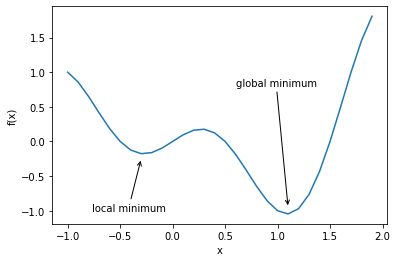

In [6]:
def f(x):
    return x * np.cos(np.pi * x)

x = np.arange(-1.0, 2.0, 0.1)
fig,  = plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                  arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)');

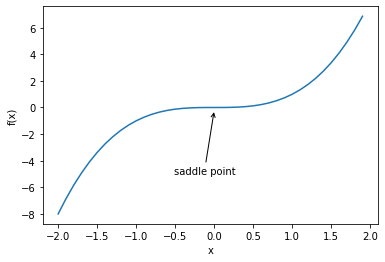

In [8]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)');

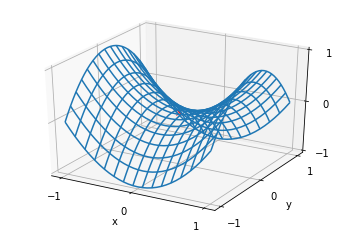

In [9]:
x, y = np.mgrid[-1: 1: 31j, -1: 1: 31j]
z = x**2 - y**2

ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'rx')
ticks = [-1,  0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y');

1. 当函数的海森矩阵在梯度为零的位置上的特征值全为正时，该函数得到局部最小值。
2. 当函数的海森矩阵在梯度为零的位置上的特征值全为负时，该函数得到局部最大值。
3. 当函数的海森矩阵在梯度为零的位置上的特征值有正有负时，该函数得到鞍点。

# SGD

epoch 10, x: 1.0737418240000007


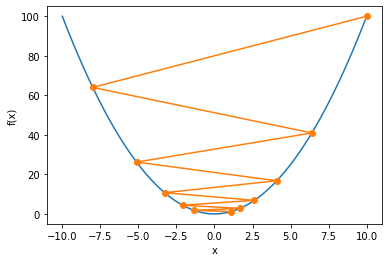

In [16]:
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * 2 * x  # f(x) = x * x的导数为f'(x) = 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.9)

def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.1)
    #d2l.set_figsize()
    plt.plot(f_line, [x * x for x in f_line])
    plt.plot(res, [x * x for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('f(x)')

show_trace(res)

epoch 20, x1 -0.607883, x2 -0.023058


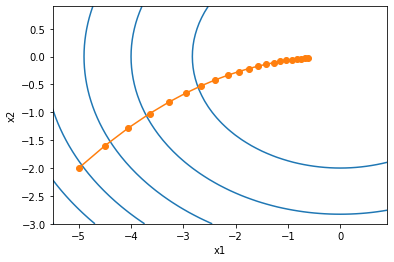

In [21]:
def train_2d(trainer):  # 本函数将保存在d2lzh_pytorch包中方便以后使用
    x1, x2, s1, s2 = -5, -2, 0, 0  # s1和s2是自变量状态，本章后续几节会使用
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):  # 本函数将保存在d2lzh_pytorch包中方便以后使用
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
eta = 0.05

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

# test optimization

In [44]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import sys
sys.path.append("..") 
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..") 
import torch
import torch.utils.data

In [47]:
data = np.genfromtxt('airfoil_self_noise.dat', delimiter='\t')
data = (data - data.mean(axis=0)) / data.std(axis=0)
features = torch.tensor(data[:1500, :-1], dtype=torch.float32)
labels = torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)
features.shape 

torch.Size([1500, 5])

# 从零开始实现

In [48]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [49]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

loss: 0.244499, 0.009906 sec per epoch
loss: 0.244076, 0.540490 sec per epoch


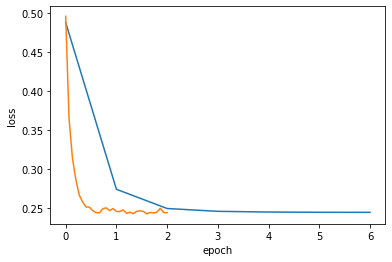

In [50]:
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = linreg, squared_loss

    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    dataset = torch.utils.data.TensorDataset(features, labels)
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失

            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)
train_sgd(0.005, 1)

In [57]:
torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9}

(torch.optim.sgd.SGD, {'lr': 0.004, 'momentum': 0.9})

# AdaGrad

我们看到当x1和x2的梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散。但这样会导致自变量在梯度值较小的维度上迭代过慢。动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。本节我们介绍AdaGrad算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题[1]。

AdaGrad算法会使用一个小批量随机梯度gt按元素平方的累加变量st。在时间步0，AdaGrad将s0中每个元素初始化为0。

在时间步tt，首先将小批量随机梯度gt按元素平方后累加到变量st

需要强调的是，小批量随机梯度按元素平方的累加变量sts 
t
​	
 出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于sts 
t
​	
 一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

epoch 20, x1 -2.382563, x2 -0.158591
epoch 20, x1 -0.002295, x2 -0.000000


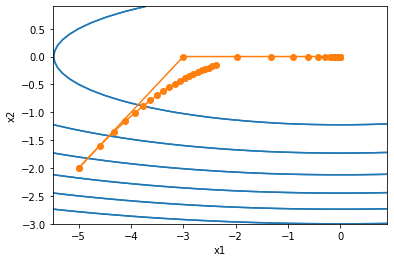

In [58]:
%matplotlib inline
import math
import torch
import sys
sys.path.append("..") 

def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  # 前两项为自变量梯度
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
show_trace_2d(f_2d, train_2d(adagrad_2d))
eta = 2
show_trace_2d(f_2d, train_2d(adagrad_2d))

- AdaGrad算法在迭代过程中不断调整学习率，并让目标函数自变量中每个元素都分别拥有自己的学习率。
- 使用AdaGrad算法时，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。

In [59]:
torch.optim.Adagrad, {'lr': 0.1}

(torch.optim.adagrad.Adagrad, {'lr': 0.1})